In [2]:
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal, AutoLowRankMultivariateNormal
from pyro.optim import ClippedAdam
from pyro.contrib.gp.kernels import RBF, Periodic, Product, RationalQuadratic, Matern32
from pyro.contrib.gp.models import VariationalSparseGP
import pandas as pd
import geopandas as gpd
import torch
import pyro
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

We have done some data retrival and preprocessing to retrieve this combined dataset

In [4]:
df = pd.read_csv('/Users/asherkite/Desktop/School/Courses/MBML/MBML_Project/MBML_github/MBML-traffic-accidents/data/df_hourly_full_Q1.csv', parse_dates=['datetime'])
df.set_index(['datetime', 'cell_id'], inplace=True)
df

acc_precip  mean_temp  \
datetime            cell_id                                            
2023-01-01 00:00:00 (721516.001, 6173966.657)         1.1     282.25   
                    (721516.001, 6174466.657)         1.1     282.25   
                    (721516.001, 6177966.657)         1.1     282.25   
                    (721516.001, 6178466.657)         1.1     282.25   
                    (722016.001, 6173966.657)         1.1     282.25   
...                                                   ...        ...   
2023-03-31 23:00:00 (726016.001, 6175966.657)         0.0     276.15   
                    (726016.001, 6176466.657)         0.0     276.15   
                    (726016.001, 6176966.657)         0.0     276.15   
                    (726016.001, 6177466.657)         0.0     276.15   
                    (726016.001, 6177966.657)         0.0     276.15   

                                               mean_relative_hum  \
datetime            cell_id                                        
2023-01-01 00:00:00 (721516.001, 6173966.657)               99.0   
                    (721516.001, 6174466.657)               99.0   
                    (721516.001, 6177966.657)               99.0   
                    (721516.001, 6178466.657)               99.0   
                    (722016.001, 6173966.657)               99.0   
...                                                          ...   
2023-03-31 23:00:00 (726016.001, 6175966.657)               90.7   
                    (726016.001, 6176466.657)               90.7   
                    (726016.001, 6176966.657)               90.7   
                    (726016.001, 6177466.657)               90.7   
                    (726016.001, 6177966.657)               90.7   

                                               mean_wind_speed  \
datetime            cell_id                                      
2023-01-01 00:00:00 (721516.001, 6173966.657)              1.6   
                    (721516.001, 6174466.657)              1.6   
                    (721516.001, 6177966.657)              1.6   
                    (721516.001, 6178466.657)              1.6   
                    (722016.001, 6173966.657)              1.6   
...                                                        ...   
2023-03-31 23:00:00 (726016.001, 6175966.657)              3.3   
                    (726016.001, 6176466.657)              3.3   
                    (726016.001, 6176966.657)              3.3   
                    (726016.001, 6177466.657)              3.3   
                    (726016.001, 6177966.657)              3.3   

                                               mean_radiation  acc_count   X  \
datetime            cell_id                                                    
2023-01-01 00:00:00 (721516.001, 6173966.657)             0.0          0 NaN   
                    (721516.001, 6174466.657)             0.0          0 NaN   
                    (721516.001, 6177966.657)             0.0          0 NaN   
                    (721516.001, 6178466.657)             0.0          0 NaN   
                    (722016.001, 6173966.657)             0.0          0 NaN   
...                                                       ...        ...  ..   
2023-03-31 23:00:00 (726016.001, 6175966.657)             0.0          0 NaN   
                    (726016.001, 6176466.657)             0.0          0 NaN   
                    (726016.001, 6176966.657)             0.0          0 NaN   
                    (726016.001, 6177466.657)             0.0          0 NaN   
                    (726016.001, 6177966.657)             0.0          0 NaN   

                                                Y  hour  
datetime            cell_id                              
2023-01-01 00:00:00 (721516.001, 6173966.657) NaN     0  
                    (721516.001, 6174466.657) NaN     0  
                    (721516.001, 6177966.657) NaN     0  
                    (721516.001, 61

Now we are building the input tensors for the LGCP model

In [5]:
df_day = df.dropna().copy()

# --- First build observation tensors

# spatial accident coordinates (km, already re-centred at SW = 0,0)
xy = df_day[["X","Y"]].values / 1_000.0
xy = xy - xy.min(0, keepdims=True)

# observed hour_of_day in accidents (0 to 23)
h_obs  = df_day["hour"].values.astype(float)

# accident space tensor (N,2)
acc_obs = torch.tensor(xy, dtype=torch.float32)

# weather observations
rain_obs = torch.tensor(df_day["acc_precip"].values,
                        dtype=torch.float32)

N, _ = acc_obs.shape

# Now build the quadrature points for the GP
# Define M quadrature points uniformly over the bounding box of coords
M_space = 1200           # spatial quadrature points. Higher is more accurate, but slower
M_time  = 24             # one for each hour
M       = M_space * M_time

# Compute bounding‐box mins and ranges as tensors
mins_xy   = torch.tensor(xy.min(0))
ranges_xy = torch.tensor(xy.max(0) - xy.min(0))

# sample spatial part
U_xy = (torch.rand(M_space,2) * ranges_xy + mins_xy)  # (M_space,2)

# deterministic hourly grid 0 to 23
U_h  = torch.arange(0,24, dtype=torch.float32).reshape(-1,1) # (24,1)
h_quad = U_h.repeat(M_space,1)  # (M,)

# study-volume = spatial-area [km²] × 24 h
area_space = (ranges_xy[0] * ranges_xy[1])         # km²
volume     = area_space * 24                       # km²·h

# make time‐bins periodic
sin_h_obs   = torch.sin(2*torch.pi*torch.tensor(h_obs))
cos_h_obs   = torch.cos(2*torch.pi*torch.tensor(h_obs))
hours   = torch.arange(M_time, dtype=torch.float32)  # [0, 1, …, 23]
sin_time = torch.sin(2 * torch.pi * hours / M_time)   # (24,)
cos_time = torch.cos(2 * torch.pi * hours / M_time)   # (24,)

# repeat each spatial point for every hour, shape (M_space * M_time, 2)
U_quad = U_xy.repeat_interleave(M_time, dim=0)

# repeat the sin/cos arrays so they line up with U_quad
sin_h_quad = sin_time.repeat(M_space)
cos_h_quad = cos_time.repeat(M_space)

# concatenate obs and quad to make the full sin_h, cos_h
sin_h = torch.cat([sin_h_obs, sin_h_quad], dim=0)
cos_h = torch.cat([cos_h_obs, cos_h_quad], dim=0)


Now we define the model according to the PGM

In [6]:
class SparseLGCP3D(pyro.nn.PyroModule):
    r"""
    Sparse-GP Log-Gaussian Cox Process with
    inputs (x,y), hour_of_day and amount of rain.
    """
    def __init__(self, spatial_kernel_cls, input_dim=2, m_inducing=500):
        super().__init__()
        self.kernel = spatial_kernel_cls(input_dim=input_dim) # (x,y) spatial kernel
        self.m_ind   = m_inducing
        self.vgp     = None

    def _ensure_vgp(self, X_all):
        if self.vgp is not None:
            return
        m = min(self.m_ind, X_all.size(0))
        Xu = X_all[torch.randperm(X_all.size(0))[:m]].contiguous()
        self.vgp = VariationalSparseGP(
            X_all, y=None, kernel=self.kernel, Xu=Xu, likelihood=None,
            jitter=1e-4, whiten=True
        )

    # -------------------------------------------------------------
    def model(self, acc_obs, U, V, sin_h, cos_h):
        """
        acc_obs     : (N,2)  spatial km (x,y)
        U           : (M,2)  quadrature spatial km
        V           : scalar area_km² * 24  (same volume used in likelihood)
        sin_h,cos_h : (N,)   sin,cos of hour/24π for obs
        """
        N = acc_obs.shape[0]
        M = U.shape[0]

        # Prior on rain‐distribution hyper‐parameters
        mu_r    = pyro.sample("mu_r",    dist.Normal(np.log(1.7), 0.5)) # based on domain knowledge
        sigma_r = pyro.sample("sigma_r", dist.HalfNormal(0.5))          # based domain knowledge

        # Latent rain-fall variable
        rain_obs  = pyro.sample(
            "rain_obs",
            dist.LogNormal(mu_r, sigma_r)
                .expand([N])
                .to_event(1)
        )   # shape (N,)

        rain_quad = pyro.sample(
            "rain_quad",
            dist.LogNormal(mu_r, sigma_r)
                .expand([M])
                .to_event(1)
        )   # shape (M,)

        # build design matrix
        sin_h_obs  = sin_h[:N]               # (N,)
        cos_h_obs  = cos_h[:N]               # (N,)
        sin_h_quad = sin_h[N:N+M]            # (M,)
        cos_h_quad = cos_h[N:N+M]            # (M,)

        Z_obs  = torch.cat([acc_obs, sin_h_obs[:, None], cos_h_obs[:, None]], dim=1)   # (N,4)
        Z_quad = torch.cat([U, sin_h_quad[:, None], cos_h_quad[:, None]], dim=1)       # (M,4)
        X_all  = torch.cat([Z_obs[:, :3], Z_quad[:, :3]], dim=0)        # (N+M,3)

        # priors for linear component 
        beta_0  = pyro.sample("beta_0", dist.Normal(-3., 1))
        beta_r  = pyro.sample("beta_r", dist.LogNormal(0., 0.3))
        gamma_sin  = pyro.sample("gamma_sin", dist.Normal(0., 1.))  # sin coeff
        gamma_cos  = pyro.sample("gamma_cos", dist.Normal(0., 1.))  # cos coeff

        # kernel hyper-priors
        ls  = pyro.sample("ls",  dist.LogNormal(np.log(5.), 0.5))
        var = pyro.sample("var", dist.LogNormal(np.log(1.), 1.0))
        noise  = pyro.sample("noise", dist.LogNormal(np.log(1e-3), 0.5))

        # inject GP hypers
        self.kernel.lengthscale = ls
        self.kernel.variance = var
        # build sparse GP prior
        self._ensure_vgp(X_all)
        self.vgp.noise = noise

        f_all = self.vgp.model()[0] # (N+M,)
        f_obs, f_quad = f_all[:N], f_all[N:]

        pyro.deterministic("f", f_all)

        # linear component
        m_obs  = beta_0 + beta_r*rain_obs + gamma_sin*sin_h_obs + gamma_sin*cos_h_obs
        m_quad = beta_0 + beta_r*rain_quad + gamma_cos*sin_h_quad[:M] + gamma_cos*cos_h_quad[:M]

        # log likelihood
        pyro.factor("obs_ll",  (m_obs  + f_obs ).sum())
        pyro.factor("quad_ll", - (V/M) * torch.exp(m_quad + f_quad).sum())

        pyro.deterministic("log_lambda_quad", m_quad + f_quad)


Run SVI inference

In [7]:
kernel_constructors = {
    #"RBF": RBF,
    "Matern 3/2": Matern32,
    #"RationalQuadratic": RationalQuadratic,
}

results = []
for name, Kcls in kernel_constructors.items():
    print(f"\n=== Sparse kernel: {name} ===")
    module = SparseLGCP3D(Kcls)
    model  = module.model
    guide  = AutoLowRankMultivariateNormal(model, init_loc_fn=pyro.infer.autoguide.init_to_median, rank=10)

    pyro.clear_param_store()
    svi = SVI(model, guide, ClippedAdam({"lr":1e-2}), Trace_ELBO())
    for step in range(500):
        loss = svi.step(acc_obs, U_quad, volume, sin_h, cos_h)
        if step % 50 == 0:
            print(f"step {step:3d}  ELBO = {-loss:.1f}") # ELBO = –loss

    final_elbo = -loss
    results.append({"kernel": name,
                    "ELBO": final_elbo,
                    "model": model,
                    "guide": guide})

df_result = pd.DataFrame(results).set_index("kernel")
print(df_result)



=== Sparse kernel: Matern 3/2 ===
step   0  ELBO = -21643.1
step  50  ELBO = -10714.7
step 100  ELBO = -4503.7
step 150  ELBO = -5343.2
step 200  ELBO = -2311.8
step 250  ELBO = -2112.3
step 300  ELBO = -2025.9
step 350  ELBO = -1415.4
step 400  ELBO = -1411.7
step 450  ELBO = -892.1
                  ELBO                                              model  \
kernel                                                                      
Matern 3/2 -880.063496  <bound method SparseLGCP3D.model of SparseLGCP...   

                                      guide  
kernel                                       
Matern 3/2  AutoLowRankMultivariateNormal()  


Obtain posterior samples and plot intensities

/tmp/ipykernel_567/1048095166.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_U_km   = U_xy + offset_km          # (M,2)


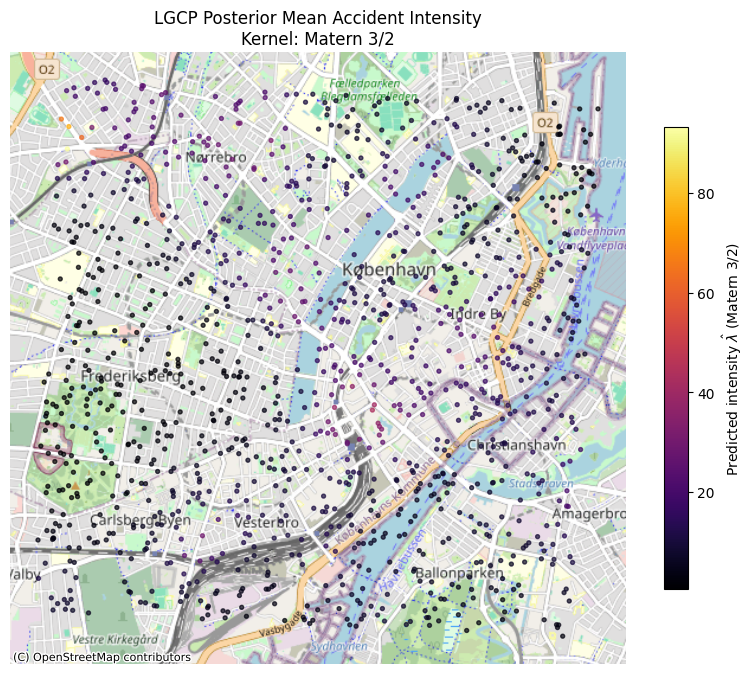

In [24]:
for name, row in df_result.iterrows():
    model = row['model']
    guide = row['guide']

    # Draw samples from the variational posterior
    predictive = Predictive(model, guide=guide, num_samples=400)
    samples    = predictive(acc_obs, U_quad, volume, sin_h, cos_h)
    
    lambda_quad_samples = torch.exp(samples["log_lambda_quad"])        # (S, M)
    lambda_quad_mean    = lambda_quad_samples.mean(0)
    
    # calculate the absolute coordinates in metres
    coords_orig = df_day[["X","Y"]].dropna().values / 1000.0  # km
    offset_km  = coords_orig.min(axis=0) # still (2,)

    # add the offset in km, then convert to metres
    abs_U_km   = U_xy + offset_km          # (M,2)
    abs_U_m    = abs_U_km * 1000.0       # (M,2)

    # Build GeoDataFrame — geometry only uses x,y
    T = 24
    S = M // T    # number of spatial locations

    # reshape into (spatial, time)
    intensity_matrix = lambda_quad_mean.reshape(S, T)        # shape (S, 24)

    # per day at location i is simply the sum over t
    daily_intensity = intensity_matrix.sum(axis=1)           # shape (S,)

    # now build your GeoDataFrame with daily_rate instead of λ_quad_mean:
    gdf = gpd.GeoDataFrame(
        {"daily_intensity": daily_intensity},
        geometry=gpd.points_from_xy(
            abs_U_km[:, 0].numpy() * 1000,
            abs_U_km[:, 1].numpy() * 1000
            ),
        crs="EPSG:25832"
    ).to_crs(epsg=3857)

    gdf_web = gdf.to_crs(epsg=3857)

    # Plot on map
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_web.plot(
        column="daily_intensity",
        ax=ax,
        markersize=8,
        alpha=0.7,
        cmap="inferno",
        legend=True,
        legend_kwds={"label": f'Predicted intensity $\\hat\\lambda$ ({name})', "shrink":0.6}
    )
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    ax.set_title(f"LGCP Posterior Mean Accident Intensity\nKernel: {name}")
    plt.tight_layout()
    plt.show()

Plot the parameter distributions

ls        mean=5.384   sd=3.014
var       mean=1.554   sd=1.731
noise     mean=0.001   sd=0.001
beta_0    mean=-2.821   sd=0.076
gamma_sin  mean=4.671   sd=0.176
gamma_cos  mean=0.021   sd=0.070
mu_r      mean=0.668   sd=0.012
sigma_r   mean=0.134   sd=0.001
beta_r    mean=1.061   sd=0.044


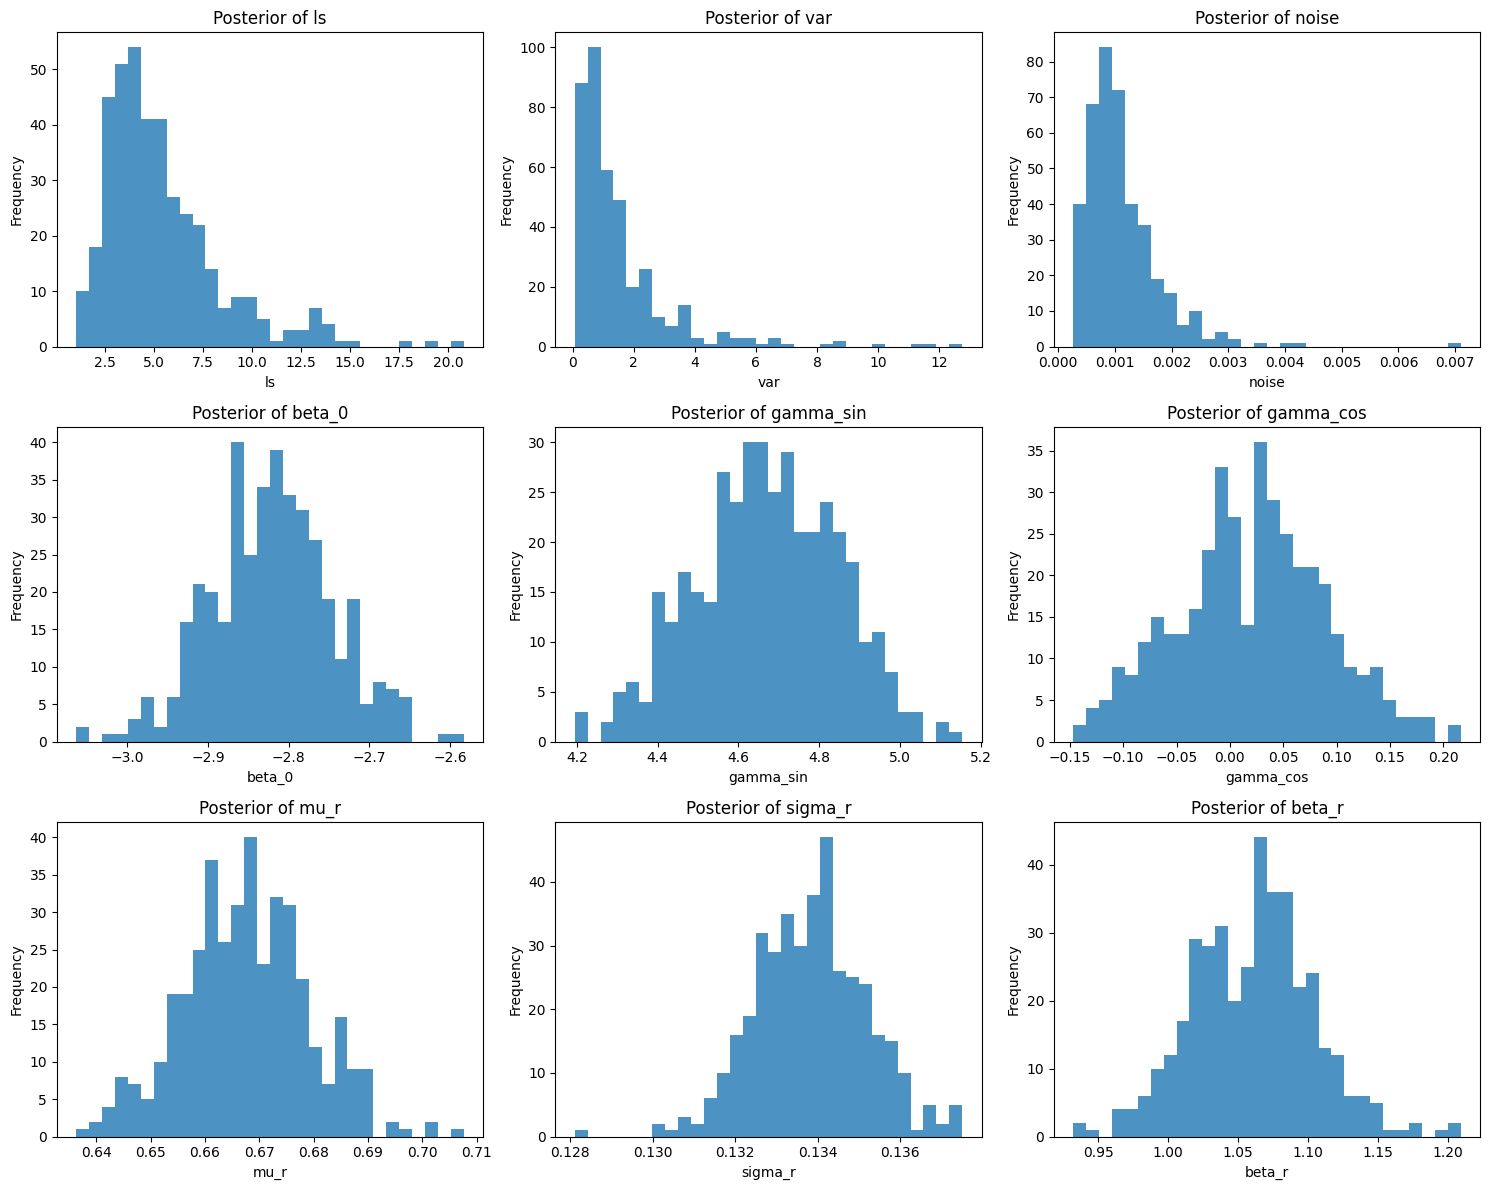

In [25]:
hyperparams = [
    "ls", "var", "noise",
    "beta_0", "gamma_sin", "gamma_cos",
    "mu_r", "sigma_r", "beta_r"

]
hp_values = {
    hp: samples[hp].detach().cpu().numpy().ravel()
    for hp in hyperparams
}

# print summary statistics
for hp, vals in hp_values.items():
    mean = np.mean(vals)
    sd   = np.std(vals)
    print(f"{hp:8s}  mean={mean:.3f}   sd={sd:.3f}")

# plot histograms in a grid
n_cols = 3
n_rows = int(np.ceil(len(hyperparams) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, hp in zip(axes, hyperparams):
    ax.hist(hp_values[hp], bins=30, alpha=0.8)
    ax.set_title(f"Posterior of {hp}")
    ax.set_xlabel(hp)
    ax.set_ylabel("Frequency")

# hide any unused subplots
for ax in axes[len(hyperparams):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

### Analytics

We can use the model to answer questions such as
1. How many accidents in a given day?
2. What is the probability of zero accidents in a day?
3. What is the probability of an accident in a given location over $t$ time?

Future questions:
4. Where is the 90 % credible hotspot? Eg. the smallest region that contains 90\% of the total predicted intensity

In [28]:
n_days = 31+28+31  # days in Jan, Feb, Mar

# compute Lambda for each posterior draw
lambda_q = torch.exp(samples["log_lambda_quad"])    # (S, M)
Lambda = (volume / M) * lambda_q.sum(dim=1)              # (S,)

# posterior expected accidents
expected_accidents = Lambda.mean().item() / n_days  # average per day
print("E[number of accidents/day] = ", expected_accidents)
print("Std[number of accidents/day] = ", Lambda.std().item() / n_days)

E[number of accidents/day] =  2.6382221579468843
Std[number of accidents/day] =  1.5162550008647104


In [29]:
Lambda_day = Lambda / n_days   # (S,)  per-day rate

p_zero_each = torch.exp(-Lambda_day)   # (S,)
p_zero = p_zero_each.mean().item()
print("P(no accidents in a day) ≈", p_zero)


P(no accidents in a day) ≈ 0.08415462400051445
